In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

In [2]:
from sklearn.utils import shuffle

def _split_data(x_data, y_data=None, train_ratio=0, split_type='uniform'):
    if split_type == 'uniform' and y_data is not None:
        pos_idx = y_data > 0
        x_pos = x_data[pos_idx]
        y_pos = y_data[pos_idx]
        x_neg = x_data[~pos_idx]
        y_neg = y_data[~pos_idx]
        train_pos = int(train_ratio * x_pos.shape[0])
        train_neg = int(train_ratio * x_neg.shape[0])
        x_train = np.hstack([x_pos[0:train_pos], x_neg[0:train_neg]])
        y_train = np.hstack([y_pos[0:train_pos], y_neg[0:train_neg]])
        x_test = np.hstack([x_pos[train_pos:], x_neg[train_neg:]])
        y_test = np.hstack([y_pos[train_pos:], y_neg[train_neg:]])
    elif split_type == 'sequential':
        num_train = int(train_ratio * x_data.shape[0])
        x_train = x_data[0:num_train]
        x_test = x_data[num_train:]
        if y_data is None:
            y_train = None
            y_test = None
        else:
            y_train = y_data[0:num_train]
            y_test = y_data[num_train:]
    # Random shuffle
    indexes = shuffle(np.arange(x_train.shape[0]))
    x_train = x_train[indexes]
    if y_train is not None:
        y_train = y_train[indexes]
    return (x_train, y_train), (x_test, y_test)

#### metric tools

In [3]:
import sklearn.metrics as sm

FONT_SIZE = 13
def prettify_plot(ax):
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
    ax.legend(loc='best', prop={'size': FONT_SIZE})
    ax.grid(True)

def roc_prettify_plot(ax, set_title=True):
    prettify_plot(ax)
    ax.set_xlabel("False Positive Rate", fontsize=FONT_SIZE)
    ax.set_ylabel("True Positive Rate", fontsize=FONT_SIZE)
    if set_title:
        ax.set_title("ROC-AUC", fontsize=15)

def prc_prettify_plot(ax, set_title=True):
    ax.set_ylim(-0.05, 1.05)
    prettify_plot(ax)
    ax.set_xlabel("Recall", fontsize=FONT_SIZE)
    ax.set_ylabel("Precision", fontsize=FONT_SIZE)
    if set_title:
        ax.set_title("AUPRC", fontsize=15)
        
def printReport(test_label, predicted_result,method):
    conf_matx = sm.confusion_matrix(test_label, predicted_result)
    print("* "+method+" Confusion Matrix \n", conf_matx)

    cls_rpt = sm.classification_report(test_label, predicted_result,digits=4)
    print("* "+method+" Classification Report \n", cls_rpt)
       
    acc = np.sum(test_label == predicted_result)/test_label.size
    print(acc)


### Benchmark
#### Import original dataset

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import sys
sys.path.append('../')
from loglizer.models import LogClustering
from loglizer import dataloader, preprocessing
import pandas as pd ;
import numpy as np

struct_log = '../data/HDFS.npz' # The benchmark dataset# The structured log file
# (x_tr, y_train), (x_te, y_test) = dataloader.load_HDFS(struct_log,
#                                                            window='session', 
#                                                            train_ratio=0.5,
#                                                            split_type='uniform')
data = np.load(struct_log, allow_pickle=True)
x_data = data['x_data']
y_data = data['y_data']
(x_train, y_train), (x_test, y_test) = _split_data(x_data, y_data, 0.5, 'uniform')
# feature_extractor = preprocessing.FeatureExtractor()
# x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf')
# model = LogClustering(max_dist=0.3, anomaly_threshold=0.3)
# model.fit(x_train[y_train == 0, :]) # Use only normal samples for trainingcs

feature_extractor = preprocessing.FeatureExtractor()
x_train = feature_extractor.fit_transform(x_train, term_weighting='tf-idf')
x_test = feature_extractor.transform(x_test)

====== Transformed train data summary ======
Train data shape: 287530-by-29

====== Transformed test data summary ======
Test data shape: 287531-by-29



#### Decision tree - original

====== Model summary ======
* weighted-tree Confusion Matrix 
 [[279094     18]
 [    18   8401]]
* weighted-tree Classification Report 
               precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999    279112
           1     0.9979    0.9979    0.9979      8419

    accuracy                         0.9999    287531
   macro avg     0.9989    0.9989    0.9989    287531
weighted avg     0.9999    0.9999    0.9999    287531

0.9998747961089413
None


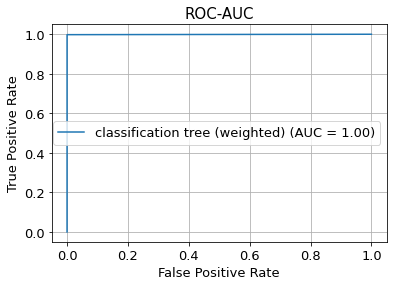

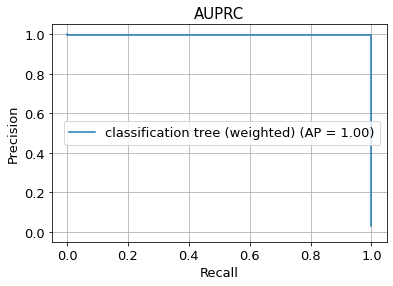

In [11]:
from loglizer.models import DecisionTree

model = DecisionTree()
model.fit(x_train, y_train)

predict_rs_a = model.predict(x_test)

print(printReport(y_test, predict_rs_a, "weighted-tree"))

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, predict_rs_a, name="classification tree (weighted)", ax=ax)
roc_prettify_plot(ax)

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_test, predict_rs_a, name="classification tree (weighted)", ax=ax)
prc_prettify_plot(ax)

#### Decision tree - weighted

* weighted-tree Confusion Matrix 
 [[279093     19]
 [    16   8403]]
* weighted-tree Classification Report 
               precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999    279112
           1     0.9977    0.9981    0.9979      8419

    accuracy                         0.9999    287531
   macro avg     0.9988    0.9990    0.9989    287531
weighted avg     0.9999    0.9999    0.9999    287531

0.999878273994804
None


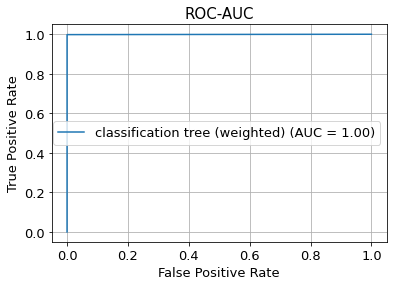

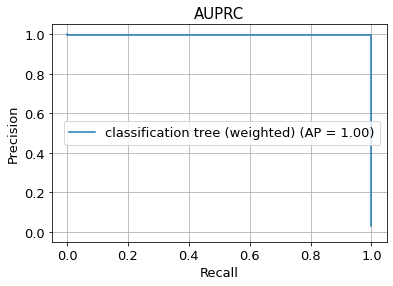

In [12]:
# Classification Tree - weighted
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

clf_default_b = DecisionTreeClassifier(class_weight="balanced")

predict_rs_b = clf_default_b.fit(x_train, y_train).predict(x_test)
print(printReport(y_test, predict_rs_b, "weighted-tree"))

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, predict_rs_b, name="classification tree (weighted)", ax=ax)
roc_prettify_plot(ax)

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_test, predict_rs_b, name="classification tree (weighted)", ax=ax)
prc_prettify_plot(ax)

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 8 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Processed 22000 instances.
Processed 24000 instances.
Processed 26000 instances.
Processed 28000 instances.
Processed 30000 instances.
Processed 32000 instances.
Processed 34000 instances.
Processed 36000 instances.
Processed 38000 instances.
Processed 40000 instances.
Processed 42000 instances.
Processed 44000 instances.
Processed 46000 instances.
Processed 48000 instances.
Processed 50000 instances.
Processed 52000 instances.
Processed 54000 instances.
Processed 56000 instances.
Processed 58000 instances.
Processed 60000 instances.
Processed 62000 instances.
Processed 64000 instances

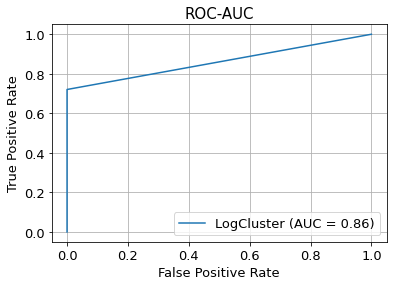

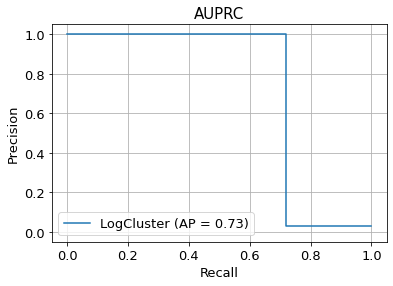

In [13]:

model_LC = LogClustering(max_dist=0.3, anomaly_threshold=0.3)
model_LC.fit(x_train[y_train == 0, :]) # Use only normal samples for training

predict_logcluster = model_LC.predict(x_test)

print(printReport(y_test, predict_logcluster, "LogCluster"))

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, predict_logcluster, name="LogCluster", ax=ax)
roc_prettify_plot(ax)


fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_test, predict_logcluster, name="LogCluster", ax=ax)
prc_prettify_plot(ax)

### Use Drain3 as Log Parser

In [6]:
from loglizer import dataloader, preprocessing
hdfs_d3_ds = pd.read_csv('../data/hdfs_log.csv')

x_data = np.array(hdfs_d3_ds['event'].str.split(' '))
y_data = np.array(hdfs_d3_ds['Label'])
(train_hdfs_d3, train_hdfs_d3_label), (test_hdfs_d3, test_hdfs_d3_label) = _split_data(x_data, y_data, 0.7, 'uniform')

feature_extractor = preprocessing.FeatureExtractor()
train_hdfs_d3 = feature_extractor.fit_transform(train_hdfs_d3, term_weighting='tf-idf')
test_hdfs_d3 = feature_extractor.transform(test_hdfs_d3)

====== Transformed train data summary ======
Train data shape: 402542-by-46

====== Transformed test data summary ======
Test data shape: 172519-by-46



#### decision tree

====== Model summary ======
* original decision dree Confusion Matrix 
 [[167467      0]
 [     7   5045]]
* original decision dree Classification Report 
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    167467
           1     1.0000    0.9986    0.9993      5052

    accuracy                         1.0000    172519
   macro avg     1.0000    0.9993    0.9996    172519
weighted avg     1.0000    1.0000    1.0000    172519

0.999959424759012
None


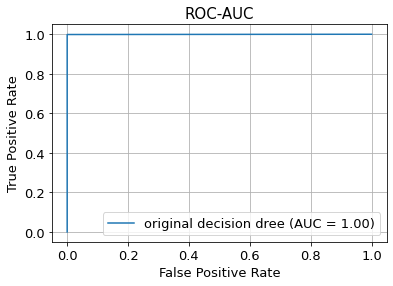

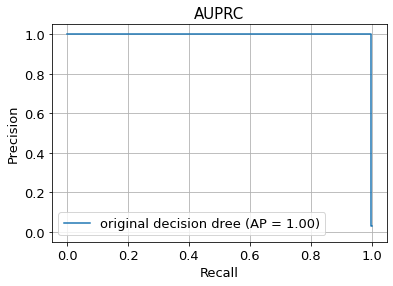

In [13]:
from loglizer.models import DecisionTree
model = DecisionTree()
model.fit(train_hdfs_d3, train_hdfs_d3_label)
d3_predict = model.predict(test_hdfs_d3)
print(printReport(test_hdfs_d3_label, d3_predict, "original decision dree"))

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(test_hdfs_d3_label, d3_predict, name="original decision dree", ax=ax)
roc_prettify_plot(ax)

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(test_hdfs_d3_label, d3_predict, name="original decision dree", ax=ax)
prc_prettify_plot(ax)

#### svm

====== Model summary ======


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


* SVM Confusion Matrix 
 [[167466      1]
 [   410   4642]]
* SVM Classification Report 
               precision    recall  f1-score   support

           0     0.9976    1.0000    0.9988    167467
           1     0.9998    0.9188    0.9576      5052

    accuracy                         0.9976    172519
   macro avg     0.9987    0.9594    0.9782    172519
weighted avg     0.9976    0.9976    0.9976    172519

0.9976176537077076
None


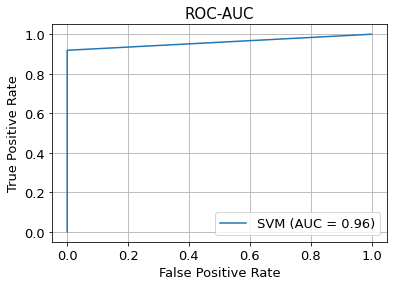

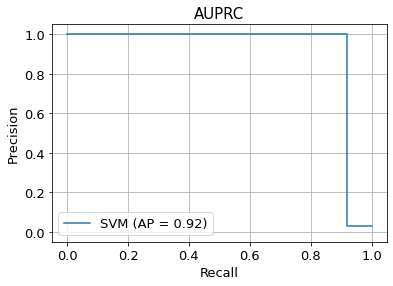

In [14]:
from loglizer.models import SVM
model = SVM()
model.fit(train_hdfs_d3, train_hdfs_d3_label)
d3_predict = model.predict(test_hdfs_d3)
print(printReport(test_hdfs_d3_label, d3_predict, "SVM"))

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(test_hdfs_d3_label, d3_predict, name="SVM", ax=ax)
roc_prettify_plot(ax)

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(test_hdfs_d3_label, d3_predict, name="SVM", ax=ax)
prc_prettify_plot(ax)

#### decision tree - weighted

* original decision dree Confusion Matrix 
 [[167467      0]
 [     7   5045]]
* original decision dree Classification Report 
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    167467
           1     1.0000    0.9986    0.9993      5052

    accuracy                         1.0000    172519
   macro avg     1.0000    0.9993    0.9996    172519
weighted avg     1.0000    1.0000    1.0000    172519

0.999959424759012
None


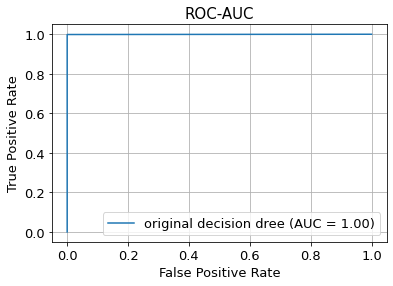

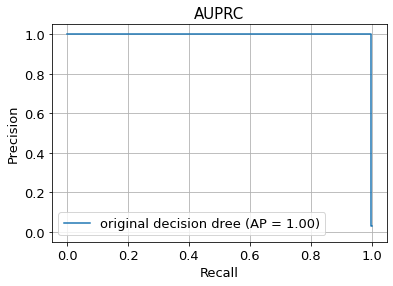

In [15]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

clf_default_b = DecisionTreeClassifier(class_weight="balanced")

d3_predict = clf_default_b.fit(train_hdfs_d3, train_hdfs_d3_label).predict(test_hdfs_d3)

print(printReport(test_hdfs_d3_label, d3_predict, "original decision dree"))

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(test_hdfs_d3_label, d3_predict, name="original decision dree", ax=ax)
roc_prettify_plot(ax)

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(test_hdfs_d3_label, d3_predict, name="original decision dree", ax=ax)
prc_prettify_plot(ax)

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 7 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Processed 22000 instances.
Processed 24000 instances.
Processed 26000 instances.
Processed 28000 instances.
Processed 30000 instances.
Processed 32000 instances.
Processed 34000 instances.
Processed 36000 instances.
Processed 38000 instances.
Processed 40000 instances.
Processed 42000 instances.
Processed 44000 instances.
Processed 46000 instances.
Processed 48000 instances.
Processed 50000 instances.
Processed 52000 instances.
Processed 54000 instances.
Processed 56000 instances.
Processed 58000 instances.
Processed 60000 instances.
Processed 62000 instances.
Processed 64000 instances

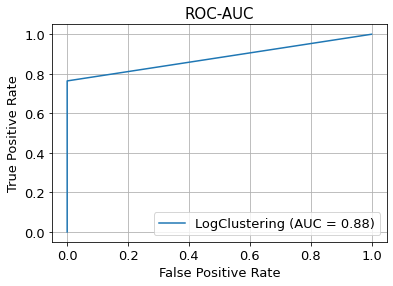

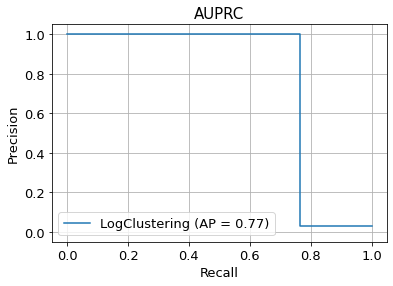

In [22]:
model_LC = LogClustering(max_dist=0.3, anomaly_threshold=0.3)
model_LC.fit(train_hdfs_d3[train_hdfs_d3_label == 0, :])

d3_predict = model_LC.predict(test_hdfs_d3)
print(printReport(test_hdfs_d3_label, d3_predict, "LogClustering"))

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(test_hdfs_d3_label, d3_predict, name="LogClustering", ax=ax)
roc_prettify_plot(ax)

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(test_hdfs_d3_label, d3_predict, name="LogClustering", ax=ax)
prc_prettify_plot(ax)

### Hadoop - templates are generated by Drain3

In [6]:
hadoop_ds = pd.read_csv('hadoop_drain3_ds.csv')

train_hadoop = np.array(hadoop_ds['events'])
test_hadoop = np.array(test_set['events'])
train_hadoop_label = train_set['label']
test_hadoop_label = test_set['label']

feature_extractor = preprocessing.FeatureExtractor()
train_hadoop = feature_extractor.fit_transform(train_hadoop, term_weighting='tf-idf')
test_hadoop = feature_extractor.transform(test_hadoop)

,identifier,events,label
0,container_1445076437777_0005_01_000004.log,"['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8...",0
1,container_1445087491445_0005_01_000007.log,"['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8...",0
2,container_1445094324383_0003_01_000018.log,"['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8...",1
3,container_1445087491445_0005_01_000013.log,"['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8...",0
4,container_1445076437777_0005_01_000010.log,"['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8...",0
...,...,...,...
975,container_1445087491445_0005_01_000022.log,"['E1', 'E2', 'E171', 'E4', 'E5', 'E6', 'E7', '...",0
976,container_1445076437777_0005_01_000009.log,"['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8...",0
977,container_1445094324383_0003_01_000001.log,"['E37', 'E4', 'E38', 'E39', 'E40', 'E41', 'E42...",1
978,container_1445094324383_0003_01_000015.log,"['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8...",1


In [1]:
model_LC = LogClustering(max_dist=0.3, anomaly_threshold=0.3)
model_LC.fit(train_rs[train_label == 0, :]) # Use only normal samples for training

predict_logcluster = model_LC.predict(test_rs)

print(printReport(test_label, predict_logcluster, "LogCluster"))

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(test_label, predict_logcluster, name="LogCluster", ax=ax)
roc_prettify_plot(ax)

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(test_label, predict_logcluster, name="LogCluster", ax=ax)
prc_prettify_plot(ax)

NameError: name 'LogClustering' is not defined